# Introduction

In this example, we will analyse a ROOT file containing inclusive $e^+ e^- \to Z^0 \to b\bar{b}$ events generated with Pythia and Delphes in FCCSW. The command used to generate this sample is:

`
./run fccrun Sim/SimDelphesInterface/options/PythiaDelphes_config_IDEA.py --Filename Generation/data/ee_Z_bbbar.cmd -n 10000
`

where the `ee_Z_bbbar.cmd` file was created from the `ee_Z_ddbar.cmd` example by changing the quark number to `5` (for $b$-quarks). The config file is based on the options shown [here](https://github.com/clementhelsens/fcc-tutorials/blob/9ab4f18c8ded529204e0077d9e4bca1a133a59a8/FCCsnowmass.md). The ROOT file is loaded using the `uproot` package, and the goal of the analysis is to produce an invariant mass peak for the $D^0 \to K^- \pi^+$ decay. 

The $b$-quarks produced in the $Z^0$ decay quickly hadronise to different types of $b$-hadrons such as $B^0$, $B^\pm$, and $B_s^0$ mesons. Many $D^0$ mesons are then produced when these mesons decay, due to the favoured nature of the $b \to c$ quark transition. Around 4% of the $D^0$ mesons then decay to a kaon and a pion. To search for the $D^0 \to K^- \pi^+$ decay, we make combinations of kaons and pions using the `awkward array` package.

## First some imports of what we need

We load `uproot4` (will eventually be called just `uproot`) and `awkward1` (will eventually be just `awkward`) to load the ROOT files and analyse them. We load `numpy` for some numerical operations, and `matplotlib` for plotting. We will make use of the `particle` package to give us information on the PDG ID and mass of various particles. We also load functions from the main project code directory `fcc_python_tools`.  

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

## Loading the ROOT file with uproot

Now we load the ROOT tree using `uproot`, where we point it at some simulated data in the FCC-ee EOS folder. The TTree is called `events` in the FCC simulation output.

In [2]:
file = uproot.open("/eos/experiment/fcc/ee/tmp/test.root")
tree = file['events']
tree.keys()

['Electron',
 'Electron#0',
 'Electron#0/Electron#0.index',
 'Electron#0/Electron#0.collectionID',
 'Muon',
 'Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'EFlowNeutralHadron',
 'EFlowNeutralHadron/EFlowNeutralHadron.type',
 'EFlowNeutralHadron/EFlowNeutralHadron.energy',
 'EFlowNeutralHadron/EFlowNeutralHadron.energyError',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.positionError[6]',
 'EFlowNeutralHadron/EFlowNeutralHadron.iTheta',
 'EFlowNeutralHadron/EFlowNeutralHadron.phi',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.shapeParameters_begin',
 'EFlowNeutralHadron/EFlowNeutralHadron.shapeParameters_end',
 'EFlowNeutralHadron/EFlowNeutralHadr

We can check how many events are in our tree - this should match the number of events generated in Pythia.

In [3]:
tree.num_entries

10000

A useful summary of the tree contents is given by the `show()` function, which shows the name, ROOT variable type, and type as interepted by `uproot` and `awkward array`.

In [4]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Electron             | std::vector<edm4hep::... | AsJagged(AsStridedObjects(M...
Electron#0           | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'El...
Electron#0/Electr... | int32_t[]                | AsJagged(AsDtype('>i4'))
Electron#0/Electr... | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon                 | std::vector<edm4hep::... | AsJagged(AsStridedObjects(M...
Muon#0               | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Mu...
Muon#0/Muon#0.index  | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon#0/Muon#0.col... | int32_t[]                | AsJagged(AsDtype('>i4'))
EFlowNeutralHadron   | vector<edm4hep::Clust... | AsGroup(<TBranchElement 'EF...
EFlowNeutralHadro... | int32_t[]                | AsJagged(AsDtype('>i4'))
EFlowNeutralHadro... | float[]                  | AsJagged

## Accessing specific particles

Next we get the stable charged hadrons and load them into an `awkward array`. The charged hadrons live in the `ReconstructedParticles` container in the ROOT file.

We get a list of all variables in the tree using `tree.keys()`. We then keep the variables relating to the `ReconstructedParticles` container, and also filter out the `covMatrix` variable. This variable has a fixed-length array form, and can't be loaded into a zipped awkward array with other single-value variables. We load the `keep_vars` into an awkward array called `h`.

In [5]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_container = "ReconstructedParticles"
h_c = f'{h_container}/{h_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_c in v):
        keep_vars.append(v)

h = tree.arrays(keep_vars,how="zip")

## Calculating some new variables and making cuts

Because `awkward array` operates at array level, we can process all events and particles in each event with single line commands. Loops can also be written, and even sped up using `numba`, but we won't consider this here.

Here we calculate the $p$ and $p_T$ of the hadrons, using the existing momentum components stored in the ROOT file.

In [6]:
h[h_c,'p'] = kinematics.calc_p(h,h_c)
h[h_c,'pt'] = kinematics.calc_pt(h,h_c)
h[h_c,'phi'] = kinematics.calc_phi(h,h_c)
h[h_c,'eta'] = kinematics.calc_eta(h,h_c)

Note the syntax here - because we zipped the array, we can access specific branches with `h[h_c,var_name]`. As a reminder, `h_c` is the location of the hadrons in the ROOT file (`ReconstructedParticles/ReconstructedParticles`). We follow the same syntax when calculating a new variable - so `p` and `pt` are added as new branches for our hadrons.

The `kinematics.calc_p/pt` functions come from the `fcc_python_tools` directory of this project - they are not `awkward array` methods. If you want to calculate more variables, you can add them into `fcc_python_tools` or just define them directly in your code. Generally, if you are going to reuse the function in several places, it's best to put it somehwere general. 

Now that we have a $p$ branch, we can define a cut to apply on it like this:

In [7]:
p_cut = h[h_c,'p'] > 1.

This requires that all of the hadrons we want to consider have $p > 2$ GeV. To apply this cut to the hadrons, we do:

In [8]:
h = h[p_cut]

In the same way, we can get samples of pions and kaons from our general hadrons array by cutting on the `pdgId`. We add them as extra members of our `h` array like this:

In [9]:
pi_cut = abs(h[h_c,'mass'] - abs(lp.pi_plus.mass)/1000.) < 1e-4
h["pi"] = h[h_c][pi_cut]

k_cut = abs(h[h_c,'mass'] - abs(lp.K_plus.mass)/1000.) < 1e-4
h["k"] = h[h_c][k_cut]

Here we have made use of the [particle](https://github.com/scikit-hep/particle) package, which provides access to various bits of information on PDG particles. We specifically use the `literals` module, which provides shortcuts to a bunch of common particles - these can be found [here](https://github.com/scikit-hep/particle/blob/master/src/particle/shared_literals.py). When we do `lp.pi_plus.pdgid`, we are getting the PDG ID of the pion.


## Making particle combinations

There are extremely helpful combinatorics functions provided by `awkward array`, namely `combinations()` for particles in the same container and `ak.cartesian()` for particles from different containers. We can use the `cartesian()` function to find all $K\pi$ pairs in every event. 

In [10]:
D = ak.cartesian({"k": h["k"], "pi": h["pi"]})

Our kaons and pions are both positively and negatively charged. For physical track combinations, we want the kaon and pion to have opposite charge. We can do this with a cut as follows:

In [11]:
D_cut = np.sign(D["k","charge"]) != np.sign(D["pi","charge"])
D = D[D_cut]

Now we can calculate the invariant mass of our $K\pi$ pairs, and look for a $D^0$ peak! We use a function from `kinematics` to do this, and pass in a list of the particles to combine and a corresponding list of their rest masses. We take the rest masses from the `particle` package, again accessing the information via the `literals` module. So `lp.K_plus.mass` gives us the rest mass of the charged kaon.

In [12]:
PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics.mass([D["k"], D["pi"]], [PDG_K_m, PDG_pi_m])

To look at only those $K\pi$ combinations consistent with a $D^0$, we can cut around the PDG $D^0$ mass:

In [13]:
PDG_D_m = lp.D_0.mass/1000.
D_cut = abs(D["mass"] - PDG_D_m) < 0.025
D = D[D_cut]

We now make a quick histogram of the $K\pi$ invariant mass, using the `matplotlib` `hist` function:

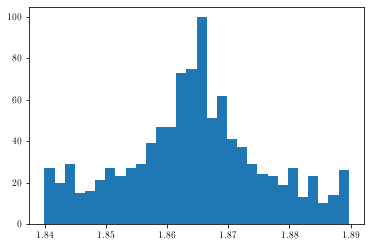

In [14]:
plt.hist(ak.flatten(D["mass"]), bins=30)
plt.show()

Note the use of `ak.flatten()` here, which is the `awkward array` function that turns the jagged data into non-jagged (which `matplotlib` requires). What this means in pratice is that all $D^0$ candidates from all events are shown together - so if an event happens to contain two $K\pi$ combinations passing our requirements, both of them will be added to the histogram.

## Pretty plotting

An example function which takes the `D["mass"]` values and plots them in a pretty error bar plot is provided. It is run with:

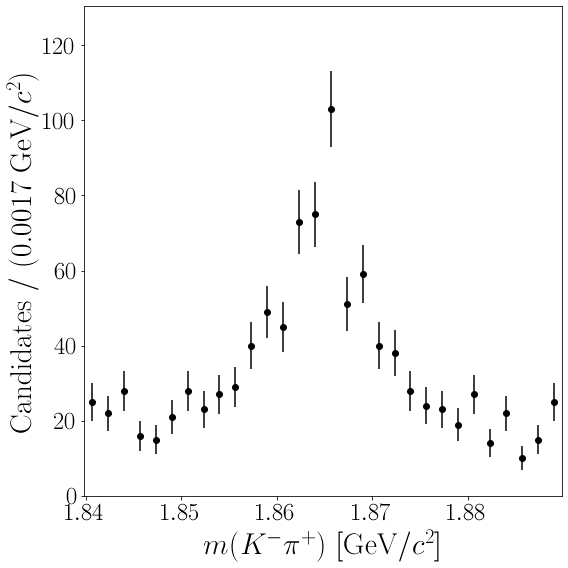

In [15]:
low = PDG_D_m - 0.025
high = PDG_D_m + 0.025
plotting.errorbar_hist(D,"mass","D","$m(K^- \pi^+)$","GeV/$c^2$",low,high,30)

Here we pass the function the array containing our D candidates (`D`), the variable we want to plot (`mass`), the name of the particle which gets added to the output file name for the plot ("D"), the x-axis title, and the histogram lower and upper limits.